In [1]:
import matplotlib.pyplot as plt
import vtk
import numpy as np
import sys
import math
import os
import glob
from vtk.util.numpy_support import *
import pandas

from skimage import segmentation

In [2]:
def read_vti(filename):
    reader = vtk.vtkXMLImageDataReader()
    reader.SetFileName(filename)
    reader.Update()
    return reader.GetOutput()

def write_vti(filename,data):
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetInputData(data)
    writer.SetFileName(filename)
    writer.Update()

def compute_3d_to_1d_map(x,y,z,dimx,dimy,dimz):
    return x + dimx*(y+dimy*z)

def get_cumulative_hist(data, nbins):
    hist = np.histogram(data,nbins)[0]
    totPts = sum(hist)
    ## compute cumulative distribution
    hist = hist/float(totPts)
    cum_dist = np.cumsum(hist)
    return cum_dist

def get_emd(dist1,dist2):
        
    emd = 0
    for i in range(len(dist1)):
        emd = emd + np.absolute(dist1[i]-dist2[i])
    return emd


def compute_avg_likelihood(hist_prev, hist_prev_edges, block_data, totBlockPts):
    
    numPts =  len(block_data)
    numBins = len(hist_prev)
    
    avg_likelihood = 0
   
    for i in range(numPts):
        for j in range(numBins):
            
            data_val = block_data[i]
            
            if data_val >= hist_prev_edges[j] and data_val <= hist_prev_edges[j+1]:
                avg_likelihood = avg_likelihood + hist_prev[j]/float(totBlockPts)
                
                break
            else:
                continue
    
    avg_likelihood = avg_likelihood / float(numPts)
    
    return avg_likelihood


def get_likelihood(hist, hist_edges, data_val):
    totBlockPts = sum(hist)
    likelihood = 0.0

    for i in range(len(hist)):
        if data_val >= hist_edges[i] and data_val <= hist_edges[i+1]:
            likelihood = hist[i]/float(totBlockPts)
    
    return likelihood

In [12]:
## MFIX bubble data
xdim = 128
ydim = 16
zdim = 128

xbox = 4
ybox = 16
zbox = 4

totPts = xbox*ybox*zbox
totPtsBlock = xbox*ybox*zbox

nbins = 64
initstep = 75
tsteps = 80
window = 1

feature_dist_input = '../feature_dists/bubble_hist_3.csv'

data_path = '/disk1/MFIX_bubble_fields/original_timestep_'
varname = 'ImageScalars'
first_tstep = '/disk1/MFIX_bubble_fields/original_timestep_0.vti'
out_file_path1 = '../out/mfix_case_3/classified_similarity_'
out_file_path2 = '../out/mfix_case_3/classified_temporal_'
out_file_path3 = '../out/mfix_case_3/pervoxel_similarity_'

In [30]:
# ## Isabel data: update the values first

# xdim = 250
# ydim = 250
# zdim = 50

# xbox = 5
# ybox = 5
# zbox = 5

# totPts = xbox*ybox*zbox
# totPtsBlock = xbox*ybox*zbox

# nbins = 64
# tsteps = 48
# initstep = 0

# feature_dist_input = '../feature_dists/isabel_hist.csv'

# data_path = '/disk1/isabel_pressure_all/Pressure_'
# varname = 'ImageFile'
# first_tstep = '/disk1/isabel_pressure_all/Pressure_0.vti'
# out_file_path1 = '../out/isabel_case_1/classified_similarity_'
# out_file_path2 = '../out/isabel_case_1/classified_temporal_'

In [5]:
# ## ExaAM data
# xdim = 20
# ydim = 200
# zdim = 50

# xbox = 4
# ybox = 10
# zbox = 5

# totPts = xbox*ybox*zbox
# totPtsBlock = xbox*ybox*zbox

# nbins = 64
# tsteps = 106
# initstep = 1

# feature_dist_input = '../feature_dists/exam_feature_3.csv'

# data_path = '/disk1/exaAM/exaam-temperatures/vti_format/plt_temperature_'
# varname = 'temperature'
# first_tstep = '/disk1/exaAM/exaam-temperatures/vti_format/plt_temperature_1.vti'
# out_file_path1 = '../out/exaAM_case_3/classified_similarity_'
# out_file_path2 = '../out/exaAM_case_3/classified_temporal_'

In [179]:
# ## vortex data
# xdim = 128
# ydim = 128
# zdim = 128

# nbins = 64
# initstep = 10
# tsteps = 30
# window = 10

# xbox = 4
# ybox = 4
# zbox = 4

# totPtsBlock = xbox*ybox*zbox

# feature_dist_input = '../feature_dists/vortex.csv'

# data_path = '/disk2/Source_Codes/multivar_sampling/Data/vortex_vti/vortex_'
# varname = 'ImageScalars'
# first_tstep = '/disk2/Source_Codes/multivar_sampling/Data/vortex_vti/vortex_10.vti'
# out_file_path1 = '../out/vortex/classified_similarity_'
# out_file_path2 = '../out/vortex/classified_temporal_'
# out_file_path3 = '../out/vortex/pervoxel_similarity_'

In [196]:
# ## isabel data
# xdim = 250
# ydim = 250
# zdim = 50

# nbins = 64
# initstep = 25
# tsteps = 30
# window = 5

# xbox = 5
# ybox = 5
# zbox = 5

# totPtsBlock = xbox*ybox*zbox

# feature_dist_input = '../feature_dists/isabel_pressure_eye_1.csv'

# data_path = '/disk2/Source_Codes/multivar_sampling/Data/Isabel_vti/isabel_p_'
# varname = 'Pressure'
# first_tstep = '/disk2/Source_Codes/multivar_sampling/Data/Isabel_vti/isabel_p_25.vti'
# out_file_path1 = '../out/isabel/classified_similarity_'
# out_file_path2 = '../out/isabel/classified_temporal_'
# out_file_path3 = '../out/isabel/pervoxel_similarity_'

[326   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   5   7   0   9   0  10   0   9  11   0   9
   0  11  11   0  14   0  22  31   0  55   0  65  75   0  85   0  69  57
   0  38   0  23   9   0   2   0   4   3] 960
[0.33958333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00520833 0.00729167 0.         0.009375   0.
 0.01041667 0.         0.009375   0.01145833 0.         0.009375
 0.         0.01145833 0.01145833 0.         0.01458333 0.
 0.02291667 0.03229167 0.         0.05729167 0.         0.06770833
 0.078125   0.         0.08854167 0.         0.071875   0.059375
 0.         0.03958333 0.         0.02395833 0.009375   0.
 0.00208333 0.         0.00416667 0.003125  ] 1.0


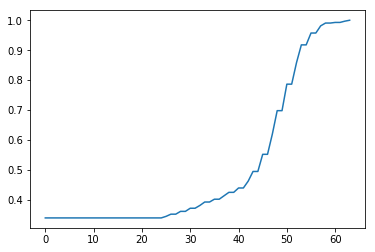

In [7]:
## load feature distribution
df = pandas.read_csv(feature_dist_input)
feature_dist = np.asarray(df['bin_values'])

# plt.plot(feature_dist)
feature_points = sum(feature_dist)

print feature_dist, feature_points

feature_dist = feature_dist/float(feature_points)
print feature_dist, sum(feature_dist)

## compute cumulative distribution
cum_feature_dist = np.cumsum(feature_dist)

plt.plot(cum_feature_dist)

In [13]:
### compare with given feature
for ii in range(initstep,tsteps,window):
    
    print 'processing tstep ' + str(ii)
    
    data_file = data_path + str(ii) + '.vti'
    
    data = read_vti(data_file)
    np_var_array = vtk.util.numpy_support.vtk_to_numpy(data.GetPointData().GetArray(varname))
    ## note that np_var_array has x and z swapped
    
    np_var_array = np.reshape(np_var_array,(zdim,ydim,xdim))
    classified_array = np.zeros_like(np_var_array)
    
    for k in range(0,zdim,zbox):
        for j in range(0,ydim,ybox):
            for i in range(0,xdim,xbox):
            
                ## note that np_var_array has x and z swapped. SO, k index in given first
                block_data = np_var_array[k:k+zbox, j:j+ybox, i:i+xbox] 
                #print k,k+zbox, j,j+ybox, i,i+xbox, block_data 
                block_data = block_data.reshape(totPtsBlock)
                cum_block_dist = get_cumulative_hist(block_data, nbins)

                ## compute EMD
                emd = get_emd(cum_feature_dist,cum_block_dist)
                classified_array[k:k+zbox, j:j+ybox, i:i+xbox] = emd
                
                
    classified_array = classified_array.reshape(xdim*ydim*zdim)
    classified_array_vtk = vtk.util.numpy_support.numpy_to_vtk(classified_array)
    classified_array_vtk.SetName('feature_similarity')
    data.GetPointData().AddArray(classified_array_vtk)

    out_fname = out_file_path1 + str(ii) + '.vti'
    write_vti(out_fname,data)

processing tstep 75
processing tstep 76
processing tstep 77
processing tstep 78
processing tstep 79


In [69]:
## look changes over time
data = read_vti(first_tstep)

np_var_array = vtk.util.numpy_support.vtk_to_numpy(data.GetPointData().GetArray(varname))
## note that np_var_array has x and z swapped
np_var_array = np.reshape(np_var_array,(zdim,ydim,xdim))

classified_array_emd = np.zeros_like(np_var_array)

classified_array_likelihood = np.zeros_like(np_var_array)

hist_temporal = []
hist_temporal_bin_edges = []
for k in range(0,zdim,zbox):
    for j in range(0,ydim,ybox):
        for i in range(0,xdim,xbox):

            ## note that np_var_array has x and z swapped. SO, k index in given first
            block_data = np_var_array[k:k+zbox, j:j+ybox, i:i+xbox] 
            block_data = block_data.reshape(totPtsBlock)
            hist = np.histogram(block_data,nbins)
            hist_temporal.append(hist[0])
            hist_temporal_bin_edges.append(hist[1])
                       
######################################################################################################
for ii in range(initstep+1,tsteps,10):
    
    print 'processing tstep ' + str(ii)
    
    data_file = data_path + str(ii) + '.vti'

    data = read_vti(data_file)
    np_var_array = vtk.util.numpy_support.vtk_to_numpy(data.GetPointData().GetArray(varname))
    ## note that np_var_array has x and z swapped
    np_var_array = np.reshape(np_var_array,(zdim,ydim,xdim))
    classified_array = np.zeros_like(np_var_array)
    
    idx = 0
    for k in range(0,zdim,zbox):
        for j in range(0,ydim,ybox):
            for i in range(0,xdim,xbox):
            
                ## note that np_var_array has x and z swapped. So, k index in given first
                block_data = np_var_array[k:k+zbox, j:j+ybox, i:i+xbox] 
                block_data = block_data.reshape(totPtsBlock)
                ## compute current histogram
                HH = np.histogram(block_data,nbins)
                
                ## lookup the histogram from previous timestep
                hist_prev = hist_temporal[idx]
                hist_prev_edges = hist_temporal_bin_edges[idx] 
                
#                 ## compute average likelihood of new points in old/previous histogram
#                 ## New idea: Instead of doing EMD we can do this
#                 ####################################################################
#                 avg_likelihood = compute_avg_likelihood(hist_prev, hist_prev_edges, block_data, totPtsBlock)
#                 classified_array_likelihood[k:k+zbox, j:j+ybox, i:i+xbox] = avg_likelihood
                
                ##EMD based comparison
                #######################################################################
                ## compute cumulative distribution of current block
                cum_dist1 = np.cumsum(HH[0]/float(totPtsBlock))
                temp = hist_prev/float(totPtsBlock)
                cum_dist2 = np.cumsum(temp)             
                ##compute EMD over time for current block
                emd_final = get_emd(cum_dist1,cum_dist2)    
                classified_array_emd[k:k+zbox, j:j+ybox, i:i+xbox] = emd_final
                
                ##update the temporal histogram array with the latest histogram
                hist_temporal[idx] = HH[0]
                hist_temporal_bin_edges[idx] = HH[1]
                idx=idx+1
                
                
    classified_array = classified_array_emd.reshape(xdim*ydim*zdim)
    classified_array_vtk = vtk.util.numpy_support.numpy_to_vtk(classified_array)
    classified_array_vtk.SetName('feature_temporal')
    data.GetPointData().AddArray(classified_array_vtk)

    out_fname = out_file_path2 + str(ii) + '.vti'
    write_vti(out_fname,data)

processing tstep 1
processing tstep 11
processing tstep 21
processing tstep 31
processing tstep 41
processing tstep 51
processing tstep 61
processing tstep 71
processing tstep 81
processing tstep 91
processing tstep 101
processing tstep 111
processing tstep 121
processing tstep 131
processing tstep 141
processing tstep 151
processing tstep 161
processing tstep 171
processing tstep 181
processing tstep 191
processing tstep 201
processing tstep 211
processing tstep 221
processing tstep 231
processing tstep 241
processing tstep 251
processing tstep 261
processing tstep 271
processing tstep 281
processing tstep 291
processing tstep 301
processing tstep 311
processing tstep 321
processing tstep 331
processing tstep 341
processing tstep 351
processing tstep 361
processing tstep 371
processing tstep 381
processing tstep 391
processing tstep 401


In [195]:
### Per voxel neighborhood distribution matching instead of block-based comparison

neighborhood_x = 2
neighborhood_y = 2
neighborhood_z = 2

for ii in range(initstep,tsteps):
    
    print 'processing tstep ' + str(ii)
    
    data_file = data_path + str(ii) + '.vti'
    
    data = read_vti(data_file)
    np_var_array = vtk.util.numpy_support.vtk_to_numpy(data.GetPointData().GetArray(varname))
    ## note that np_var_array has x and z swapped
    
    np_var_array = np.reshape(np_var_array,(zdim,ydim,xdim))
    classified_array = np.zeros_like(np_var_array)
    
    ## do for each grid point
    for k in range(0,zdim):
        for j in range(0,ydim):
            for i in range(0,xdim):
            
                ## note that np_var_array has x and z swapped. SO, k index in given first
                
                if (k-neighborhood_z) >= 0:
                    kmin = (k-neighborhood_z)
                else:
                    kmin = 0
                
                if (k+neighborhood_z) <= zdim:
                    kmax = (k+neighborhood_z)
                else:
                    kmax = zdim
                    
                if (j-neighborhood_y) >= 0:
                    jmin = (j-neighborhood_y)
                else:
                    jmin = 0
                
                if (j+neighborhood_y) <= ydim:
                    jmax = (j+neighborhood_y)
                else:
                    jmax = ydim
                    
                if (i-neighborhood_x) >= 0:
                    imin = (i-neighborhood_x)
                else:
                    imin = 0
                
                if (i+neighborhood_x) <= xdim:
                    imax = (i+neighborhood_x)
                else:
                    imax = xdim    
                
                block_data = np_var_array[kmin:kmax, jmin:jmax, imin:imax] 
                
                totPtsBlock = np.shape(block_data)[0]*np.shape(block_data)[1]*np.shape(block_data)[2]
                
                block_data = block_data.reshape(totPtsBlock)
                cum_block_dist = get_cumulative_hist(block_data, nbins)

                ## compute EMD
                emd = get_emd(cum_feature_dist,cum_block_dist)
                classified_array[k, j, i] = emd
                
                
    classified_array = classified_array.reshape(xdim*ydim*zdim)
    classified_array_vtk = vtk.util.numpy_support.numpy_to_vtk(classified_array)
    classified_array_vtk.SetName('feature_similarity')
    data.GetPointData().AddArray(classified_array_vtk)

    out_fname = out_file_path3 + str(ii) + '.vti'
    write_vti(out_fname,data)

processing tstep 25
processing tstep 26


AttributeError: 'NoneType' object has no attribute 'GetDataType'

In [211]:
## load feature distribution
feature_dist_input = '../feature_dists/mfix_bubble_datavals_1.csv'
df = pandas.read_csv(feature_dist_input)
feature_data = np.asarray(df['ImageScalars'])
hist = np.histogram(block_data,nbins)
hist_bins = hist[0]
hist_edges = hist[1]

### compare each point and see how much it is part of the histogram
for ii in range(initstep,tsteps,window):
    
    print 'processing tstep ' + str(ii)
    
    data_file = data_path + str(ii) + '.vti'
    
    data = read_vti(data_file)
    np_var_array = vtk.util.numpy_support.vtk_to_numpy(data.GetPointData().GetArray(varname))
    ## note that np_var_array has x and z swapped
    
    np_var_array = np.reshape(np_var_array,(zdim,ydim,xdim))
    classified_array = np.zeros_like(np_var_array)
    
    for k in range(0,zdim):
        for j in range(0,ydim):
            for i in range(0,xdim):
            
                val =  np_var_array[k, j, i] 
                
                ## compare data
                comp_val = get_likelihood(hist_bins, hist_edges, val)
                classified_array[k, j, i] = comp_val
                
                
    classified_array = classified_array.reshape(xdim*ydim*zdim)
    classified_array_vtk = vtk.util.numpy_support.numpy_to_vtk(classified_array)
    classified_array_vtk.SetName('feature_similarity')
    data.GetPointData().AddArray(classified_array_vtk)

    out_fname = out_file_path1 + str(ii) + '.vti'
    write_vti(out_fname,data)

processing tstep 75
processing tstep 80


KeyboardInterrupt: 